In [23]:
import torch
import torch.nn.functional as F
from torch import nn
import pandas as pd
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pprint import pprint

In [24]:
torch.__version__

'2.4.0'

In [25]:
device = torch.device("cuda")
device

device(type='cuda')

In [26]:
text = open("/kaggle/input/war-and-peace/war_and_peace.txt", mode='r')
lines = text.readlines()
words = pd.Series(lines)
words 

0        "Well, Prince, so Genoa and Lucca are now just...
1        Buonapartes. But I warn you, if you don't tell...
2        if you still try to defend the infamies and ho...
3        Antichrist--I really believe he is Antichrist-...
4        to do with you and you are no longer my friend...
                               ...                        
20376    on the steps in the "reception room"--as Denis...
20377    hut--and it was then so warm that the officers...
20378    always some with Denisov and Rostov, sat in th...
20379                                                   \n
20380                        In April, Rostov was on order
Length: 20381, dtype: object

In [27]:
words = words.str.lower()
words = words.str.strip()
words = words.str.replace("\n", "")
words = words.str.replace('"', '')
words = words.str.replace(',', '')
words = words.str.replace('.', '')
words = words.str.replace('!', '')
words = words.str.replace("'", "")
words = words.str.replace("-", "")
words = words.str.replace("?", "")
words = words.str.replace("(", "")
words = words.str.replace(")", "")
words = words.str.replace(";", "")
words = words.str.replace(":", "")
words = words.str.strip()

In [28]:
words = words.sample(frac=1).reset_index(drop=True)
words = words.tolist()

In [29]:
words[:10]

['bilibin smiled and the wrinkles on his face disappeared',
 '',
 '',
 'but when katie brought the required dress princess mary remained',
 'sitting down a person of very high standing in our brotherhood has',
 '',
 'ah mon ami i only pray and hope that god will hear me andrew',
 'cupboards and little tables the quilt of a high white feather bed was',
 '',
 'influence of the dark graceful girl who loved another']

In [30]:
chars = sorted(list(set((" ".join(words)).split(" "))))
stoi = {s:i+2 for i,s in enumerate(chars)}
stoi['.'] = 1
stoi['<S>'] = 0
itos = {i:s for s,i in stoi.items()}
print(len(itos))

11189


In [31]:
block_size = 8 # context length: how many words/characters do we take to predict the next one?
X, Y = [], []
for w in words[:]:
  
  # print(w)
  context = [0] * block_size
  for ch in (w.split(" ") + ['<S>']):
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
# Move data to GPU

X = torch.tensor(X).to(device)
Y = torch.tensor(Y).to(device)

In [32]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([204978, 8]), torch.int64, torch.Size([204978]), torch.int64)

In [33]:
emb_dim = 64
emb = torch.nn.Embedding(len(stoi), emb_dim)
emb.weight

Parameter containing:
tensor([[ 0.2372,  1.9250,  0.6089,  ...,  0.8193,  0.1778,  1.3461],
        [-1.4355, -0.9897, -0.3779,  ...,  0.0169,  0.5929, -0.5732],
        [-1.0342, -0.1171, -2.3710,  ...,  1.8205,  1.4348, -0.9079],
        ...,
        [ 0.6659, -0.1431, -0.9542,  ...,  1.4911, -0.5877, -0.0709],
        [ 0.1556,  1.8370, -0.1944,  ..., -0.2080,  0.2242,  0.1826],
        [ 0.3375,  0.1123, -1.4037,  ..., -0.4114,  0.4565, -0.4666]],
       requires_grad=True)

In [34]:
class NextChar(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim, hidden_size):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lin1 = nn.Linear(block_size*emb_dim, hidden_size)
        self.lin2 = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        x = self.emb(x)
        x = x.view(x.shape[0], -1)
        x = nn.functional.tanh(self.lin1(x))
        x = self.lin2(x)
        return x 
    


In [35]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

model = NextChar(block_size, len(stoi), emb_dim, 512).to(device)
model = torch.compile(model)

g = torch.Generator()
g.manual_seed(4000002)
def generate_words(model, itos, stoi, block_size, max_len=100):
    context = [0] * block_size
    name = ''
    for i in range(max_len):
        x = torch.tensor(context).view(1, -1).to(device)
        y_pred = model(x)
        ix = torch.distributions.categorical.Categorical(logits=y_pred).sample().item()
        # print(ix)
        ch = itos[ix]
        if ch == '<S>':
            break
        if ch not in ['"', ',', '.', '!', "'", "-", "?", "(", ")", ";", ":"]:
            name += ' '+ ch
        else:
            name += ch
        context = context[1:] + [ix]
    return name

for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

W1027 06:20:31.717000 140417444616000 torch/_dynamo/convert_frame.py:1009] WON'T CONVERT forward /tmp/ipykernel_31/2313360188.py line 8 
W1027 06:20:31.717000 140417444616000 torch/_dynamo/convert_frame.py:1009] due to: 
W1027 06:20:31.717000 140417444616000 torch/_dynamo/convert_frame.py:1009] Traceback (most recent call last):
W1027 06:20:31.717000 140417444616000 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 948, in __call__
W1027 06:20:31.717000 140417444616000 torch/_dynamo/convert_frame.py:1009]     result = self._inner_convert(
W1027 06:20:31.717000 140417444616000 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10/site-packages/torch/_dynamo/convert_frame.py", line 472, in __call__
W1027 06:20:31.717000 140417444616000 torch/_dynamo/convert_frame.py:1009]     return _compile(
W1027 06:20:31.717000 140417444616000 torch/_dynamo/convert_frame.py:1009]   File "/opt/conda/lib/python3.10

 sturdy statesman defeat associations penitence grateful dolokhov denuded unobserved unappreciated kaiser go grown lolled handsome shrugging societys dulm nicholas lie chandelier strategically podolian readily youturn proof generosity purifying inspected base tenderness therefore directing bone subside affectionate idea groom scraggy drubetskaya satisfied dissipation model cogs jena wagon meddle enthusiastic housethat hold handled convulsed hacking repress envious selfish unfriendly writes faro glow proof saute cowardice carried bids thick paler clerki weighty enemys nation lords separate therethere differed impracticable cottage rendered hopelessness princesse marie retreats inability panting insisting pleasanter cared independent uniting gliding twirled rescue happiest admit minutest bonne parts strains disentangled castanet
 rightly associated heror carpenter rudeness upkeep watchingas commit battalionand pumps rounds without estranged sleepless bully derogates turf crying nowhe dra

In [36]:
for param_name, param in model.named_parameters():
    print(param_name, param.shape)

_orig_mod.emb.weight torch.Size([11189, 64])
_orig_mod.lin1.weight torch.Size([512, 512])
_orig_mod.lin1.bias torch.Size([512])
_orig_mod.lin2.weight torch.Size([11189, 512])
_orig_mod.lin2.bias torch.Size([11189])


In [37]:
len(stoi)

11189

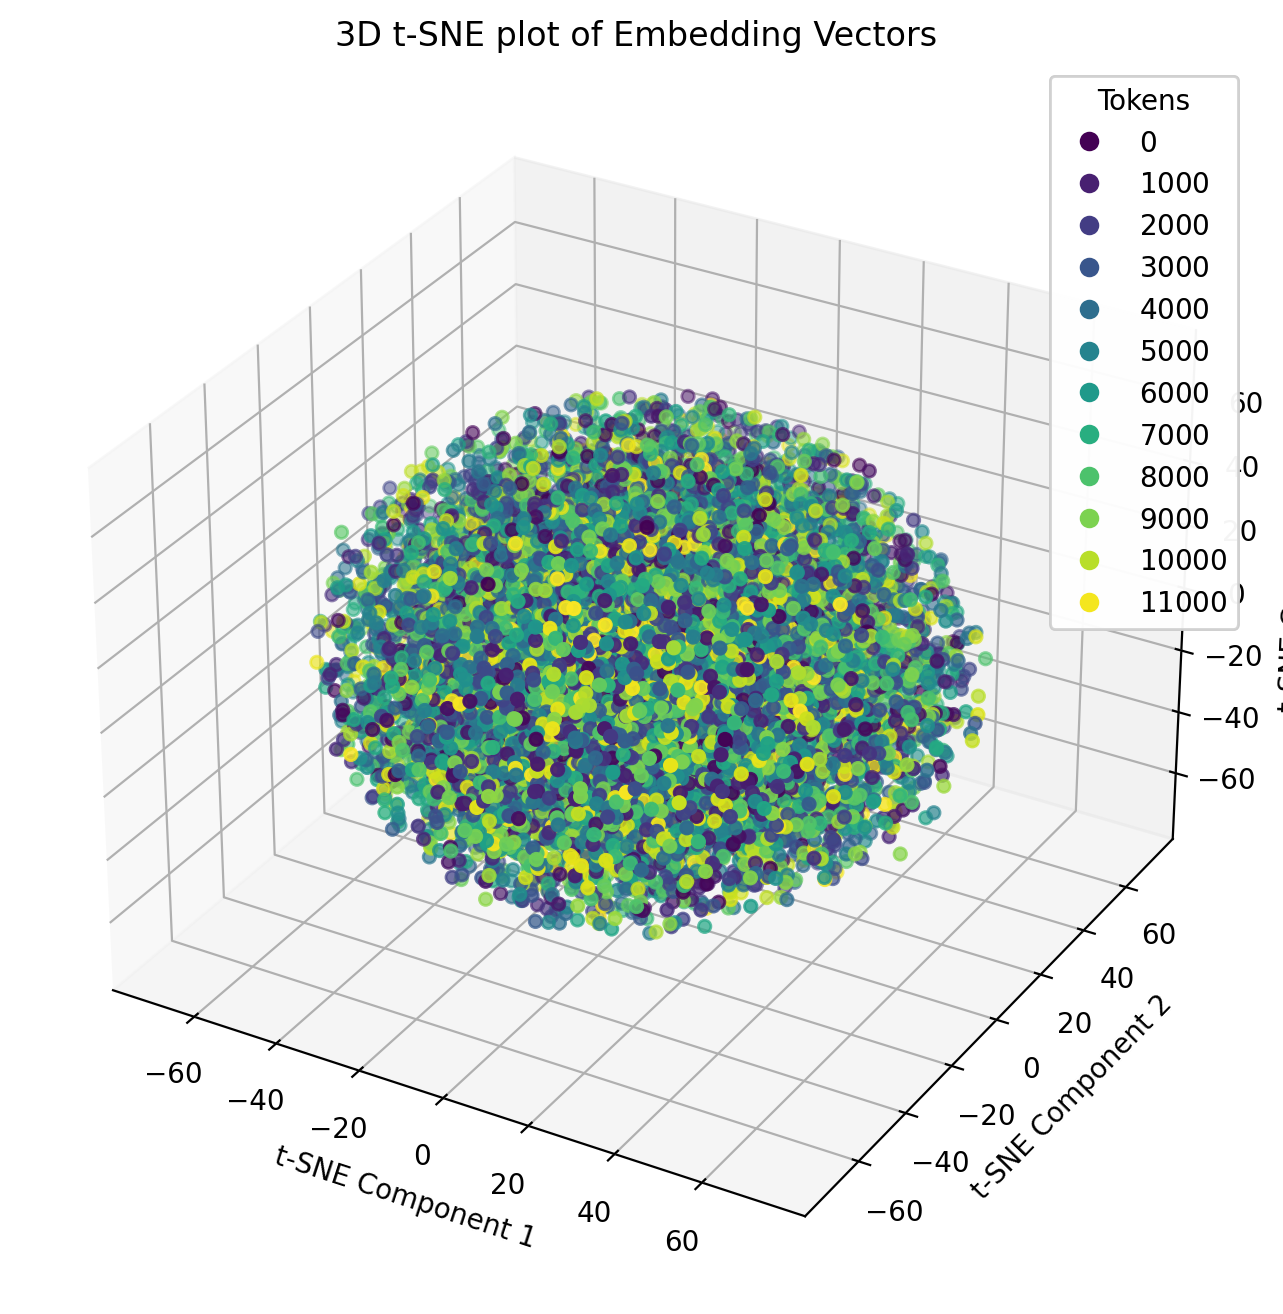

In [38]:
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

# Get the embeddings (weights of the embedding layer)
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()

In [39]:
import time
l1_lambda = 0.000007  # Regularization strength for L1 norm

# Loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.AdamW(model.parameters(), lr=0.00007)

# Mini-batch training
batch_size = 4000
print_every = 10
elapsed_time = []

for epoch in range(1000):
    start_time = time.time()
    
    for i in range(0, X.shape[0], batch_size):
        x = X[i:i+batch_size]
        y = Y[i:i+batch_size]
        
        try:
            if x.shape[0] != 0:
                # Forward pass
                y_pred = model(x)
                loss = loss_fn(y_pred, y)
                loss = loss.to(device)

                # Compute L1 norm (sum of absolute values of weights)
                l1_norm = sum(torch.sum(torch.abs(param)) for param in model.parameters())

                # Add L1 regularization to the loss
                loss += l1_lambda * l1_norm

                # Backward pass
#                 print(y_pred)
#                 print(y)
                loss.backward()
                opt.step()
                opt.zero_grad()
        except:
            pass

    end_time = time.time()
    elapsed_time.append(end_time - start_time)
    try:
        if epoch % print_every == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    except:
        pass


Epoch 0, Loss: 13.329530715942383
Epoch 10, Loss: 10.311625480651855
Epoch 20, Loss: 9.613779067993164
Epoch 30, Loss: 9.091243743896484
Epoch 40, Loss: 8.6635103225708
Epoch 50, Loss: 8.289222717285156
Epoch 60, Loss: 7.946768283843994
Epoch 70, Loss: 7.626296043395996
Epoch 80, Loss: 7.322959899902344
Epoch 90, Loss: 7.033742904663086
Epoch 100, Loss: 6.756857872009277
Epoch 110, Loss: 6.4911346435546875
Epoch 120, Loss: 6.2360992431640625
Epoch 130, Loss: 5.991979598999023
Epoch 140, Loss: 5.75903844833374
Epoch 150, Loss: 5.537741184234619
Epoch 160, Loss: 5.328420162200928
Epoch 170, Loss: 5.131396293640137
Epoch 180, Loss: 4.9468207359313965
Epoch 190, Loss: 4.774360656738281
Epoch 200, Loss: 4.613527774810791
Epoch 210, Loss: 4.463628768920898
Epoch 220, Loss: 4.3240275382995605
Epoch 230, Loss: 4.194058418273926
Epoch 240, Loss: 4.0731024742126465
Epoch 250, Loss: 3.960416793823242
Epoch 260, Loss: 3.855379104614258
Epoch 270, Loss: 3.7574119567871094
Epoch 280, Loss: 3.6660711

In [40]:
for i in range(10):
    print(generate_words(model, itos, stoi, block_size))

 princess mary after that the night was served
 were never important and that of the victory felt what looked with
 
 
 triumphantly silent herself not only kill measures and the same image handa there you wont bowed me fight
 heard the way back
 early looks at me he whispered everything was the clatter of the night
 
 
 


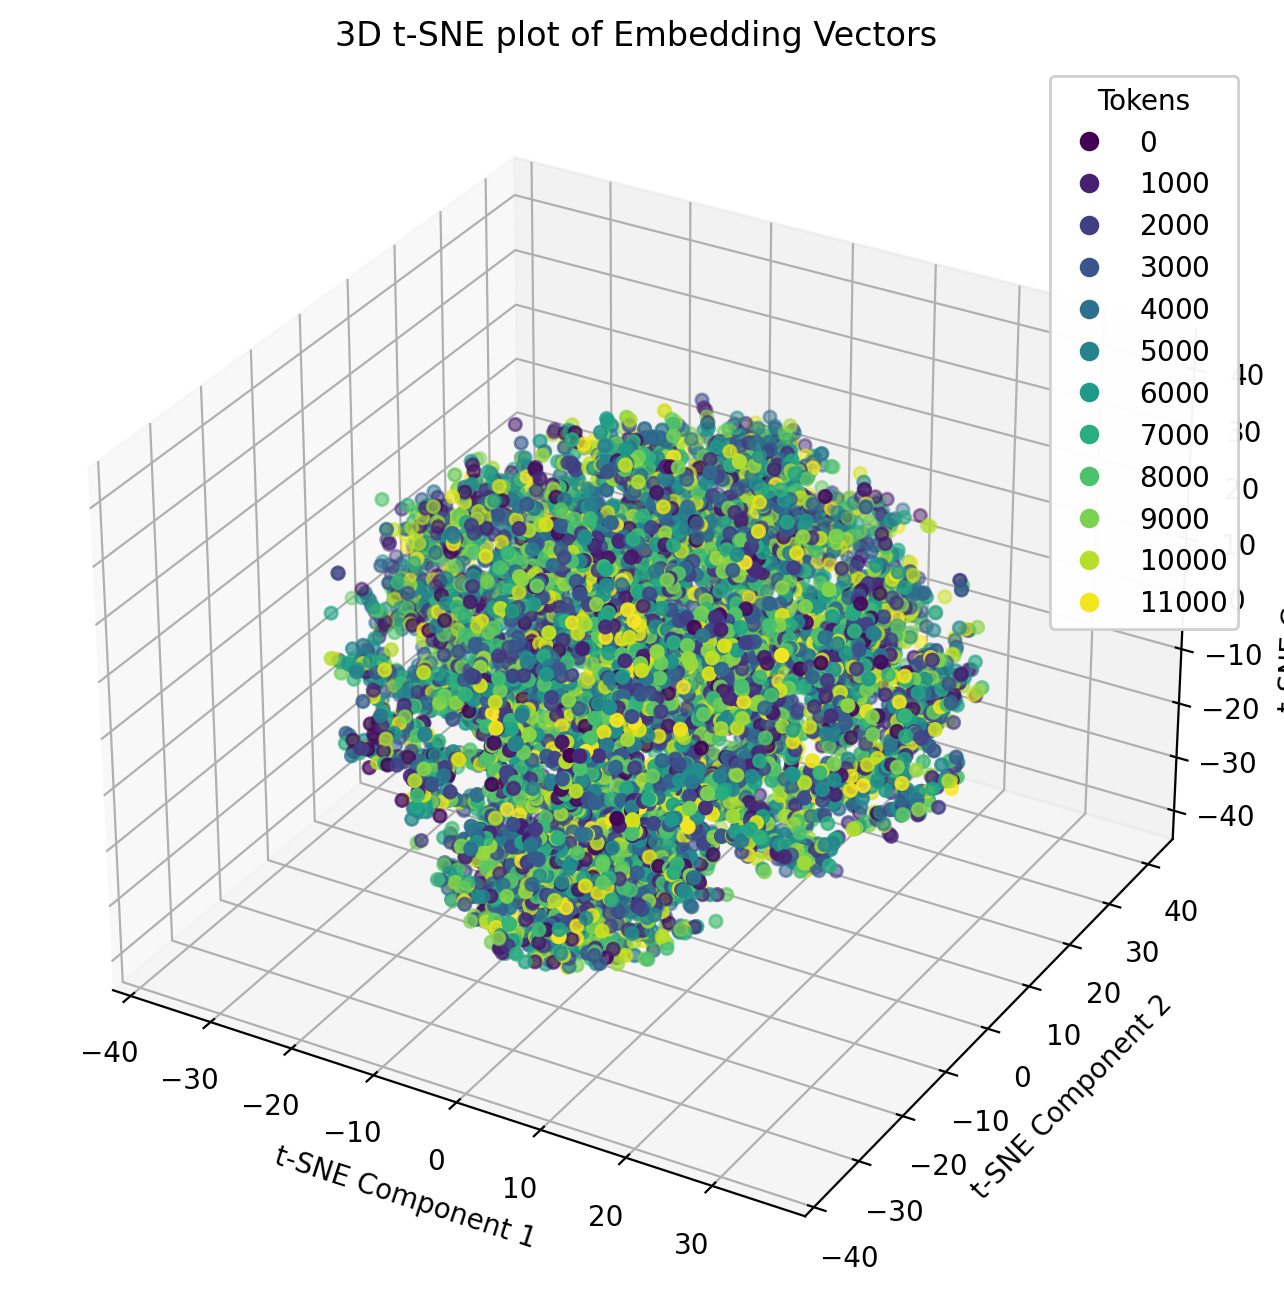

In [42]:
emb_curr = model.emb
embeddings = emb_curr.weight.detach().cpu().numpy()

# Perform PCA to reduce to 50 dimensions
pca = PCA(n_components=20, random_state=42)
embeddings_pca = pca.fit_transform(embeddings)

# Perform t-SNE on the PCA-reduced embeddings with 3 components
tsne = TSNE(n_components=3, random_state=42)
X_embedded = tsne.fit_transform(embeddings_pca)

# Get the token names (keys from stoi) in the same order as embeddings
tokens = list(stoi.keys())

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

scatter = ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], 
                     c=np.arange(len(tokens)), cmap='viridis', marker='o')

# Create legend labels based on tokens
legend1 = ax.legend(*scatter.legend_elements(), title="Tokens")
ax.add_artist(legend1)

# Add title and labels for each axis
ax.set_title('3D t-SNE plot of Embedding Vectors')
ax.set_xlabel('t-SNE Component 1')
ax.set_ylabel('t-SNE Component 2')
ax.set_zlabel('t-SNE Component 3')

plt.show()


In [45]:
model_cpu = model.cpu()

torch.save(model_cpu.state_dict(), "model_8_64_512_t.pth")

In [46]:
model = model.to(device)